In [1]:
import torch
import random

random.seed(0)
torch.manual_seed(0)

In [2]:
# Dataset
trainlistpath = "/home/liyy/data1/moco/datasets/.Fastmri_pics/trainlist.txt"
vallistpath = "/home/liyy/data1/moco/datasets/.Fastmri_pics/vallist.txt"
testlistpath = "/home/liyy/data1/moco/datasets/.Fastmri_pics/testlist.txt"

with open(trainlistpath, 'r') as f:
    trainlist = f.readlines()
    trainlist = [(line.split()[0], int(line.split()[1])) for line in trainlist]

with open(vallistpath, 'r') as f:
    vallist = f.readlines()
    vallist = [(line.split()[0], int(line.split()[1])) for line in vallist]

with open(testlistpath, 'r') as f:
    testlist = f.readlines()
    testlist = [(line.split()[0], int(line.split()[1])) for line in testlist]


from models.transforms.radial import Transform
from datasets.fastmri_320 import Fastmri_320

transform = Transform((320, 320), 500, 500).requires_grad_(False)

train_dataset = Fastmri_320(trainlist, transform=transform, output_keys=["kspace_before", "kspace_after", "pos_seq_before", "pos_seq_after", "image"], output_type=dict, num_subset=640, disk_cache=True)
val_dataset = Fastmri_320(vallist, transform=transform, output_keys=["kspace_before", "kspace_after", "pos_seq_before", "pos_seq_after", "image"], output_type=dict, num_subset=64, disk_cache=True)

print(len(train_dataset))
print(len(val_dataset))


(3, 640, 800)
torch.Size([800, 640, 2])
640
64


/mnt/data1/liyuyang/moco/models/transforms/radial.py:41: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/native/Copy.cpp:308.)
  self.traj_raw = gatraj.clone().to(torch.float32).to('cuda') # phase readout pos


/mnt/data1/liyuyang/moco/datasets/fastmri_320.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._cache[path] = torch.load(cache_path)


image:  1  16  320  320  kspace_before:  1  16  500  640  kspace_after:  1  16  500  640  pos_seq_before:  500  640  pos_seq_after:  500  640


/home/liyy/miniconda3/envs/moco/lib/python3.10/site-packages/torchkbnufft/_nufft/spmat.py:101: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/torch/csrc/utils/tensor_new.cpp:651.)
  torch.sparse.FloatTensor(inds, real_vals, torch.Size(shape)),  # type: ignore


image_recon_before:  1  16  320  320  image_recon_after:  1  16  320  320
mse 0.014267710037529469 0.014267709106206894
ssim 0.98586595 0.9858659


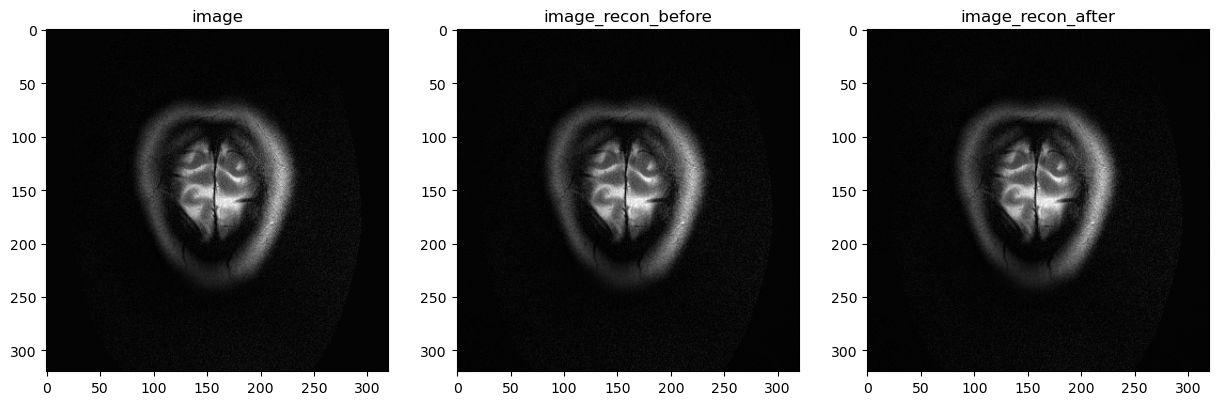

image:  1  16  320  320  kspace_before:  1  16  500  640  kspace_after:  1  16  500  640  pos_seq_before:  500  640  pos_seq_after:  500  640
image_recon_before:  1  16  320  320  image_recon_after:  1  16  320  320
mse 0.003115401603281498 0.0031154018361121416
ssim 0.99233854 0.99233854


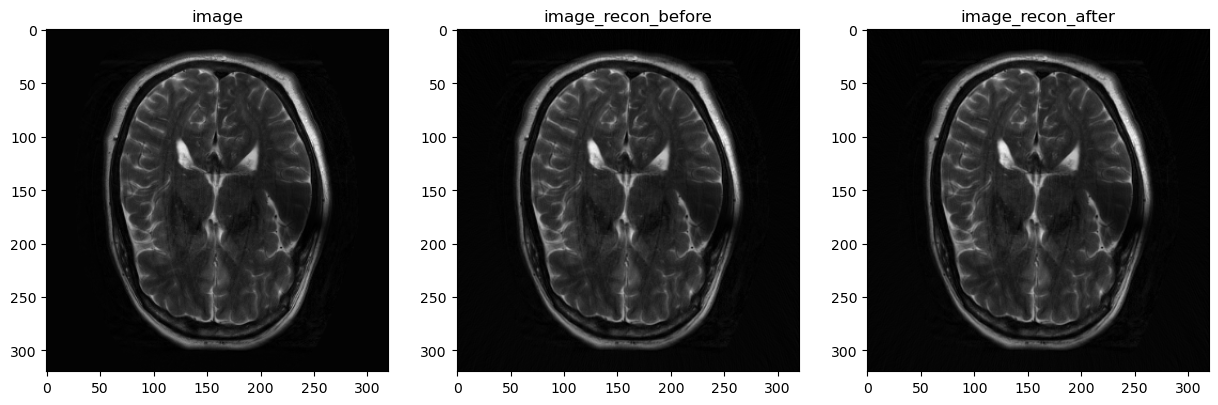

image:  1  16  320  320  kspace_before:  1  16  500  640  kspace_after:  1  16  500  640  pos_seq_before:  500  640  pos_seq_after:  500  640
image_recon_before:  1  16  320  320  image_recon_after:  1  16  320  320
mse 0.0016244661528617144 0.0016244665021076798
ssim 0.9876194 0.9876194


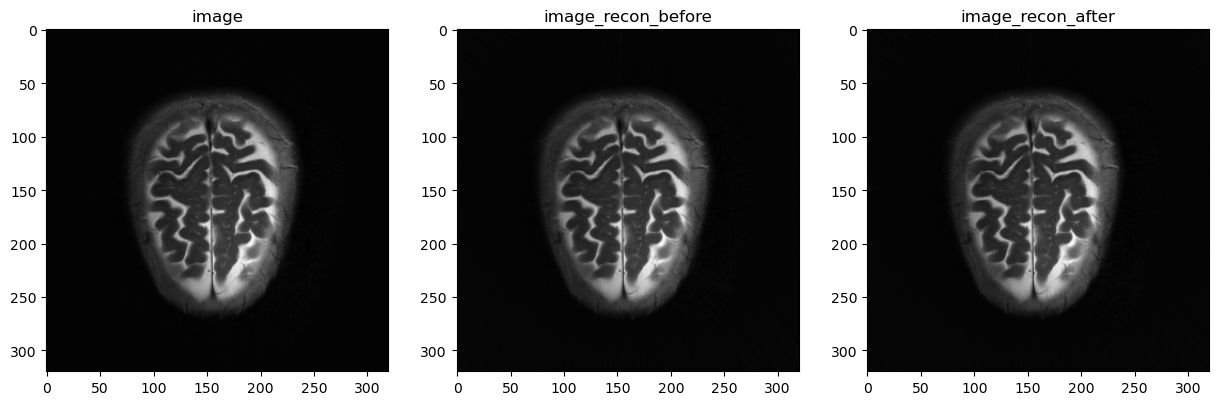

In [3]:
# show train dataset sample 0 - 5

import matplotlib.pyplot as plt
from torch.nn import functional as F
from skimage.metrics import structural_similarity
from models.mynn import functional as myf

import random

random.seed(0)

def mean_std_norm_complex(data):
    data_real = data.real
    data_imag = data.imag
    data_real = (data_real - data_real.mean()) / data_real.std()
    data_imag = (data_imag - data_imag.mean()) / data_imag.std()
    return data_real + 1j * data_imag

def mse(image1, image2):
    image1 = mean_std_norm_complex(image1)
    image1 = torch.view_as_real(image1)
    image2 = mean_std_norm_complex(image2)
    image2 = torch.view_as_real(image2)
    return F.mse_loss(image1, image2)

def ssim(image1, image2):
    image1 = mean_std_norm_complex(image1)
    image1 = myf.complex_to_real(image1).numpy()
    image2 = mean_std_norm_complex(image2)
    image2 = myf.complex_to_real(image2).numpy()
    return structural_similarity(image1[0], image2[0], channel_axis=0, data_range=image1.max() - image1.min())

for i in random.sample(range(0, len(train_dataset)), min(3, len(train_dataset))):
    sample = train_dataset[i]
    image = sample["image"].unsqueeze(0)
    kspace_full = sample["kspace_before"].unsqueeze(0)
    kspace_partial = sample["kspace_after"].unsqueeze(0)
    pos_seq_full = sample["pos_seq_before"]
    pos_seq_partial = sample["pos_seq_after"]

    # print(pos_seq_full)

    # print shapes
    print('image:', *image.shape, 'kspace_before:', *kspace_full.shape, 'kspace_after:', *kspace_partial.shape, 'pos_seq_before:', *pos_seq_full.shape, 'pos_seq_after:', *pos_seq_partial.shape, sep='  ')

    image_recon_full = transform.inufft(kspace_full, pos_seq_full)
    image_recon_partial = transform.inufft(kspace_partial, pos_seq_partial)

    print('image_recon_before:', *image_recon_full.shape, 'image_recon_after:', *image_recon_partial.shape, sep='  ')

    print('mse', mse(image, image_recon_full).item(), mse(image, image_recon_partial).item())

    print('ssim', ssim(image, image_recon_full), ssim(image, image_recon_partial))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(torch.abs(image[0][0]), cmap="gray")
    plt.title("image")
    plt.subplot(1, 3, 2)
    plt.imshow(torch.abs(image_recon_full[0][0]), cmap="gray")
    plt.title("image_recon_before")
    plt.subplot(1, 3, 3)
    plt.imshow(torch.abs(image_recon_partial[0][0]), cmap="gray")
    plt.title("image_recon_after")
    plt.show()
    
    

image:  1  16  320  320  kspace_before:  1  16  500  640  kspace_after:  1  16  500  640  pos_seq_before:  500  640  pos_seq_after:  500  640
Done.
Done.
Done.
Done.
image_recon_before:  320  320  image_recon_after:  320  320


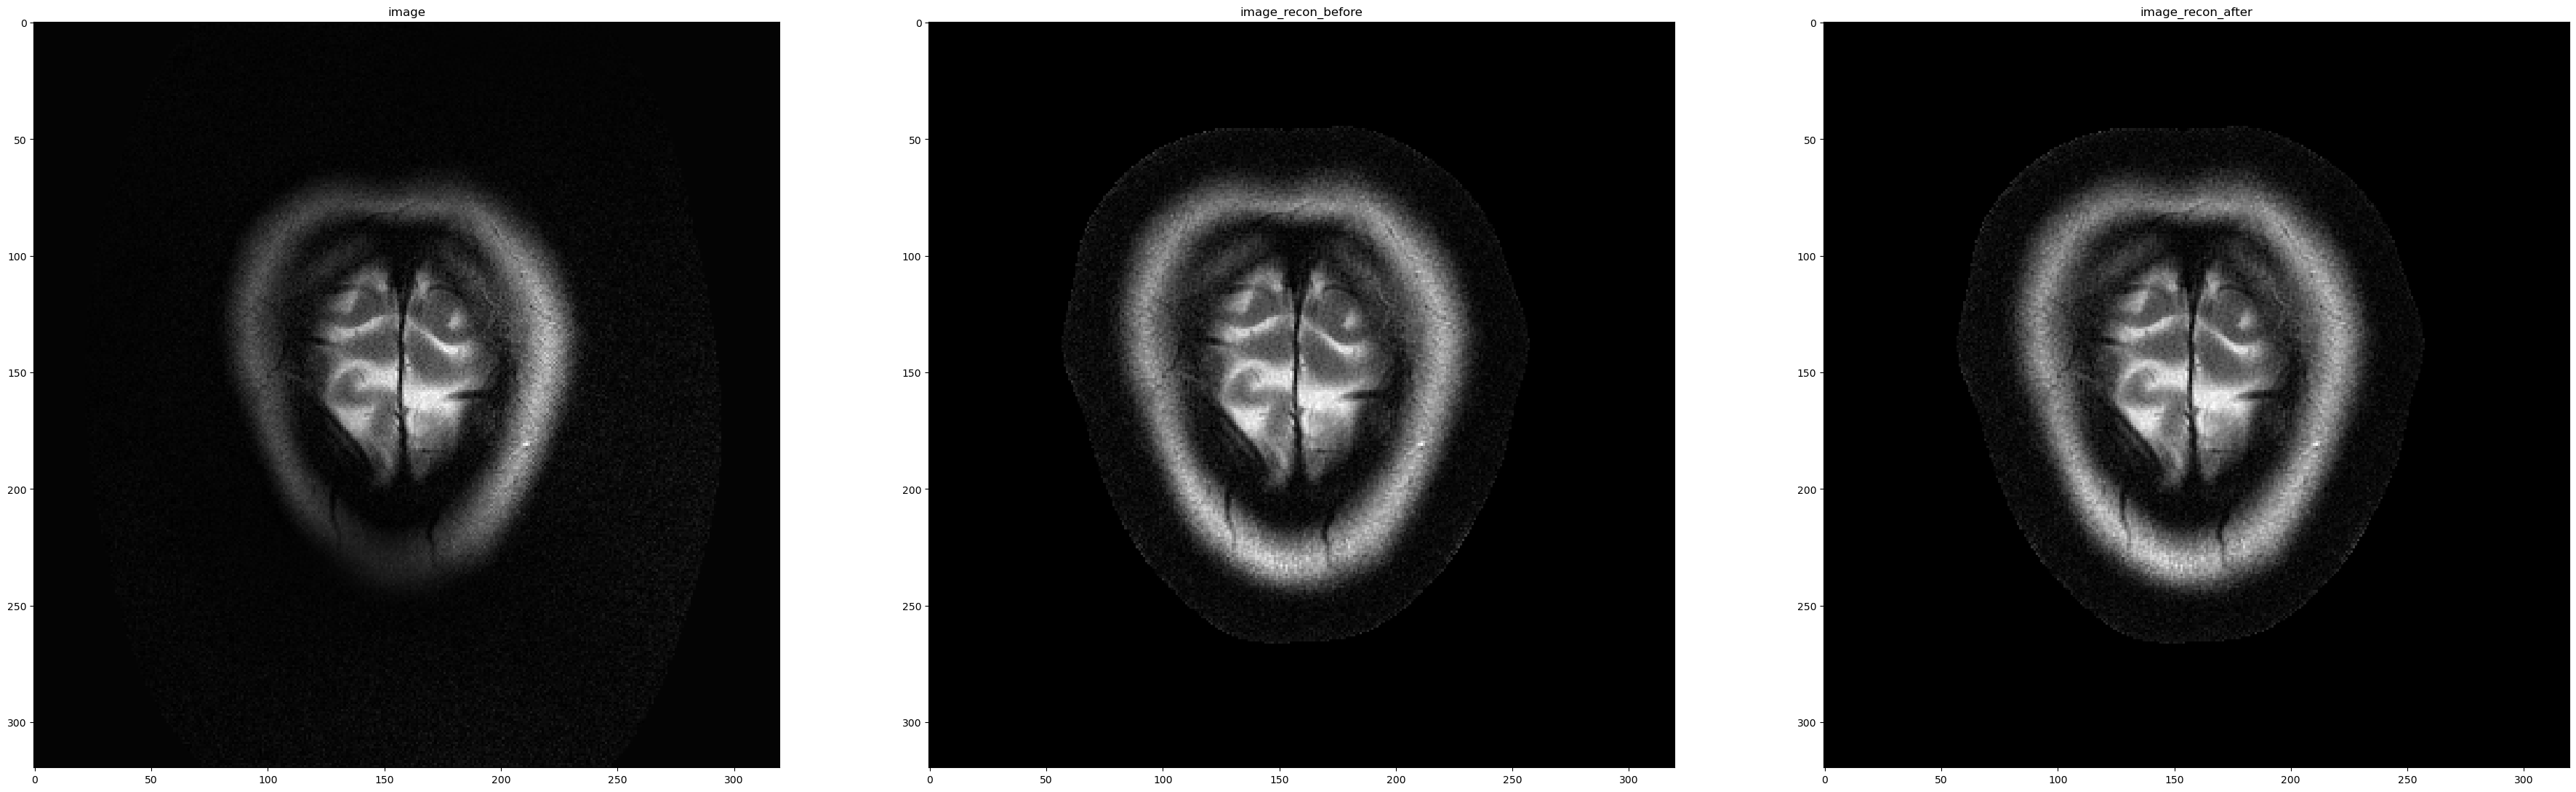

In [4]:
# bart recon

import matplotlib.pyplot as plt
from torch.nn import functional as F
from skimage.metrics import structural_similarity
from models.mynn import functional as myf

import random

from einops import rearrange, repeat

import sys
import os
sys.path.append(os.path.join(os.environ['BART_TOOLBOX_PATH'], 'python'))
from bart import bart

import numpy as np

random.seed(0)

def mean_std_norm_complex(data):
    data_real = data.real
    data_imag = data.imag
    data_real = (data_real - data_real.mean()) / data_real.std()
    data_imag = (data_imag - data_imag.mean()) / data_imag.std()
    return data_real + 1j * data_imag

def mse(image1, image2):
    image1 = mean_std_norm_complex(image1)
    image1 = torch.view_as_real(image1)
    image2 = mean_std_norm_complex(image2)
    image2 = torch.view_as_real(image2)
    return F.mse_loss(image1, image2)

def ssim(image1, image2):
    image1 = mean_std_norm_complex(image1)
    image1 = myf.complex_to_real(image1).numpy()
    image2 = mean_std_norm_complex(image2)
    image2 = myf.complex_to_real(image2).numpy()
    return structural_similarity(image1[0], image2[0], channel_axis=0, data_range=image1.max() - image1.min())


def cal_csm(kdata, ktraj, im_size):
    image = bart(1, f"nufft -x {im_size[0]}:{im_size[1]}:1 -i -g", ktraj, kdata)
    kspace= bart(1, f"fft -u 7", image)
    csm = bart(1, "ecalib -m 1", kspace)
    return csm

def pics_nuifft(kdata, ktraj, im_size):
    image = bart(1, f"nufft -x {im_size[0]}:{im_size[1]}:1 -i -g", ktraj, kdata)
    kspace= bart(1, f"fft -u 7", image)
    csm = bart(1, "ecalib -m 1", kspace)
    recon = bart(1, f'pics -S -g -d0 -R W:3:0:{0.001} -i {50}', kspace, csm)
    return recon

def pics_noncart(kdata, ktraj, im_size):
    csm = cal_csm(kdata, ktraj, im_size)
    recon = bart(1, f'pics -g -d0 -S -r{1e-4} -i {50} -t', ktraj, kdata, csm)
    return recon

def k_reshape(kdata):
    return rearrange(kdata, 'batch coil phase readout -> 1 readout phase coil 1 1 1 1 1 1 1 1 1 1 1 batch').numpy()

def pos_reshape(pos_seq):
    pos_seq = torch.view_as_real(pos_seq).to(torch.complex64)
    pos_seq = rearrange(pos_seq, " phase readout pos -> pos readout phase").numpy()
    pos_seq = np.concatenate([pos_seq, np.zeros([1, *pos_seq.shape[1:]])], axis=0)
    return pos_seq


for i in random.sample(range(0, len(train_dataset)), min(1, len(train_dataset))):
    sample = train_dataset[i]
    image = sample["image"].unsqueeze(0)
    kspace_before = sample["kspace_before"].unsqueeze(0)
    kspace_after = sample["kspace_after"].unsqueeze(0)
    pos_seq_before = sample["pos_seq_before"]
    pos_seq_after = sample["pos_seq_after"]

    # print(pos_seq_full)

    # print shapes
    print('image:', *image.shape, 'kspace_before:', *kspace_before.shape, 'kspace_after:', *kspace_after.shape, 'pos_seq_before:', *pos_seq_before.shape, 'pos_seq_after:', *pos_seq_after.shape, sep='  ')

    import sys
    import os
    sys.path.append(os.path.join(os.environ['BART_TOOLBOX_PATH'], 'python'))
    from bart import bart
    
    # print("csm:", csm.shape)
    # csm = rearrange(csm, "coil readout phase -> readout phase 1 coil 1 1 1 1 1 1 1 1 1 1 1 1").numpy()

    kspace_before = k_reshape(kspace_before)
    pos_seq_before = pos_reshape(pos_seq_before)


    image_recon_before = pics_noncart(kspace_before, pos_seq_before, (320,320))
    # image_recon_before = pics_nuifft(kspace_before, pos_seq_before, (320,320))
    image_recon_before = torch.tensor(image_recon_before)

    kspace_after = k_reshape(kspace_after)
    pos_seq_after = pos_reshape(pos_seq_after)

    
    image_recon_after = pics_noncart(kspace_after, pos_seq_after, (320,320))
    # image_recon_after = pics_nuifft(kspace_after, pos_seq_after, (320,320))
    image_recon_after = torch.tensor(image_recon_after)

    print('image_recon_before:', *image_recon_before.shape, 'image_recon_after:', *image_recon_after.shape, sep='  ')

    # print('mse', mse(image, image_recon_before).item(), mse(image, image_recon_after).item())

    # print('ssim', ssim(image, image_recon_before), ssim(image, image_recon_after))

    plt.figure(figsize=(45, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(torch.abs(image[0][0]), cmap="gray")
    plt.title("image")
    plt.subplot(1, 3, 2)
    plt.imshow(torch.abs(image_recon_before[:,:]), cmap="gray")
    plt.title("image_recon_before")
    plt.subplot(1, 3, 3)
    plt.imshow(torch.abs(image_recon_after[:,:]), cmap="gray")
    plt.title("image_recon_after")
    plt.show()

    
    

In [5]:
from torch import nn
import torch
import math
from typing import List
from einops import rearrange, repeat, pack, unpack

class SinusoidalPositionEncoding1d(nn.Module):
    """Sinusoidal Position Encoding for 1-dimensions"""
    def __init__(self, d_model, pos_scale=1e2):
        super(SinusoidalPositionEncoding1d, self).__init__()
        self.d_model = d_model
        self.pos_scale = pos_scale
        self.conv1d = nn.Conv1d(1, d_model, 1)

        self.register_buffer('_div_term', torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)))

    def forward(self, tensor = None, position = None):
        """tensor:[batch_size, seq_len, d_model]  
        position:[batch_size, seq_len, 1]  
        tensor is None: return positional encoding  
        position is None: return [0-1]*scale positional encoding for tensor  
        """
        assert tensor is not None or position is not None, "Either tensor or position must be provided"

        if position is None:
            position = torch.arange(tensor.size(1), device=tensor.device).unsqueeze(0).unsqueeze(-1).float()
        position = (position - position.min()) / (position.max() - position.min())
        position = position * self.pos_scale

        assert len(position.size()) == 3, "position must be [batch_size, seq_len, 1]"

        pe = torch.zeros(position.size(0), position.size(1), self.d_model, device=position.device)
        pe[:, :, 0::2] = torch.sin(position * self._div_term)
        pe[:, :, 1::2] = torch.cos(position * self._div_term)

        if tensor is None:
            return pe        
        return tensor + pe




class SinusoidalPositionEncodingmd(nn.Module):
    """Multi-dimensional Sinusoidal Position Encoding"""
    def __init__(self, d_model, pos_scale: float | List[float] = 1e2, n_dims=2):
        super(SinusoidalPositionEncodingmd, self).__init__()
        self.n_dims = n_dims
        self.d_model = d_model
        self.register_buffer('pos_scale', torch.tensor(pos_scale if isinstance(pos_scale, list) else [pos_scale] * n_dims))

        assert d_model % n_dims == 0, "d_model must be divisible by n_dims"
        self.register_buffer('_div_term', torch.exp(torch.arange(0, self.d_model // self.n_dims, 2).float() * -(math.log(10000.0) / self.d_model // self.n_dims)))

    
    def forward(self, tensor, position = None):
        """tensor:[batch_size, seq_len, d_model]  
        position:[batch_size, seq_len, n_dims]  
        tensor is None: return positional encoding   
        position is None: return [0-1]*scale positional encoding for tensor   
        """
        assert tensor is not None or position is not None, "Either tensor or position must be provided"

        if position is None:
            position = []
            for i in range(self.n_dims):
                pos = torch.arange(tensor.size(1), device=tensor.device).unsqueeze(0).unsqueeze(-1).float()
                position.append(pos)
            position = torch.cat(position, dim=-1)
        position = (position - position.min()) / (position.max() - position.min())
        position = position * self.pos_scale

        assert len(position.size()) == 3, "position must be [batch_size, seq_len, n_dims]"

        pe = torch.zeros(position.size(0), position.size(1), self.d_model, device=position.device)
        for i in range(self.n_dims): # [aaabbbccc]
            pe[:, :, i * self.d_model // self.n_dims:(i+1) * self.d_model // self.n_dims:2] = torch.sin(position[:, :, i:i+1] * self._div_term)
            pe[:, :, i * self.d_model // self.n_dims + 1:(i+1) * self.d_model // self.n_dims:2] = torch.cos(position[:, :, i:i+1] * self._div_term)

        if tensor is None:
            return pe
        return tensor + pe


class LearnablePositionEncoding(nn.Module):
    """Learnable Position Encoding"""
    def __init__(self, d_model, max_len=512):
        super(LearnablePositionEncoding, self).__init__()
        self.d_model = d_model
        self.max_len = max_len
        self._pe = nn.Parameter(torch.randn(max_len, d_model))

    def forward(self, tensor):
        return tensor + self._pe[:tensor.size(0), :]



import torch
from torch import nn

from einops import rearrange, repeat, pack, unpack
from einops.layers.torch import Rearrange

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x
    
class ViT(nn.Module):
    def __init__(self, *, seq_len, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert (seq_len % patch_size) == 0

        num_patches = seq_len // patch_size
        patch_dim = channels * patch_size

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (n p) -> b n (p c)', p = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, series):
        x = self.to_patch_embedding(series)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, 'd -> b d', b = b)

        x, ps = pack([cls_tokens, x], 'b * d')

        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        cls_tokens, _ = unpack(x, ps, 'b * d')

        return self.mlp_head(cls_tokens)

In [6]:
import models.mynn as mynn
from models.mynn import functional as myf

from torchkbnufft import KbNufft, KbNufftAdjoint, calc_tensor_spmatrix, calc_density_compensation_function, ToepNufft

class MAE_Kradial(nn.Module):
    def __init__(self, 
                 image_size = (320, 320),
                 mask_ratio = 0.5,
                 pts_readout = 640,
                 in_channels = 16, out_channels = 16,
                 d_model_encoder = 1024, d_model_decoder = 1024,
                 nlayers_encoder = 4, nlayers_decoder = 4,
                 nheads_encoder = 8, nheads_decoder = 8,
                 ):
        super().__init__()
        self.image_size = image_size
        self.d_model_encoder = d_model_encoder
        self.d_model_decoder = d_model_decoder
        self.nlayer_encoder = nlayers_encoder
        self.nlayer_decoder = nlayers_decoder
        self.nheads_encoder = nheads_encoder
        self.nheads_decoder = nheads_decoder
        self.mask_ratio = mask_ratio
        self.pts_readout = pts_readout
        self.in_channels = in_channels
        self.out_channels = out_channels

        ### nufft object
        self._nufft_obj = KbNufft(im_size=image_size, device='cuda')
        self._inufft_obj = KbNufftAdjoint(im_size=image_size, device='cuda')

        ### Encoder
        self.input_embed = nn.Sequential(
            mynn.IFFTn(dim = -1),
            mynn.Complex2Real(),
            Rearrange('batch channel phase readout -> batch phase (readout channel)'),
            nn.LayerNorm(pts_readout * in_channels * 2), 
            nn.Linear(pts_readout * in_channels * 2, d_model_encoder, bias=True),
            nn.LayerNorm(d_model_encoder)
        )

        self.norm_encoder = nn.LayerNorm(d_model_encoder)

        self.pe_encoder = SinusoidalPositionEncoding1d(d_model = d_model_encoder, pos_scale=100)

        self.encoder = Transformer(dim = d_model_encoder, depth = nlayers_encoder, heads = nheads_encoder, mlp_dim = 2048, dim_head = d_model_encoder // nheads_encoder)


        ### Decoder
        self.decoder_embed = nn.Linear(d_model_encoder, d_model_decoder, bias=True)

        self.pe_decoder = SinusoidalPositionEncoding1d(d_model = d_model_decoder, pos_scale=100)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, d_model_decoder))

        self.decoder = Transformer(dim = d_model_decoder, depth = nlayers_decoder, heads = nheads_decoder, mlp_dim = 2048, dim_head = d_model_decoder // nheads_decoder)

        self.norm_decoder = nn.LayerNorm(d_model_decoder)

        self.output_embed = nn.Sequential(
            nn.Linear(d_model_decoder, pts_readout * out_channels * 2, bias=True),
            Rearrange('batch phase (readout channel) -> batch channel phase readout', channel = out_channels * 2, readout = pts_readout),
            mynn.Real2Complex(),
            mynn.FFTn(dim = -1),
        )


    def nufft(self, image, traj):
        device = image.device
        image = image.to(torch.device("cuda"))
        traj = traj.to(torch.device("cuda"))

        traj_shape = traj.shape
        traj = traj / 160 * torch.pi # bart normalization to torchkbnufft normalization
        traj = torch.view_as_real(traj)
        traj = rearrange(traj, 'phase readout pos -> pos (readout phase)')

        res = self._nufft_obj(image, traj)
        res = rearrange(res, '... (readout phase) ->... phase readout', phase=traj_shape[0], readout=traj_shape[1])

        res = res.to(device)
        return res
    
    def inufft(self, kspace, traj):
        device = kspace.device
        kspace = kspace.to(torch.device("cuda"))
        traj = traj.to(torch.device("cuda"))

        traj_shape = traj.shape
        traj = traj / 160 * torch.pi # bart normalization to torchkbnufft normalization
        traj = torch.view_as_real(traj)
        traj = rearrange(traj, 'phase readout pos -> pos (readout phase)')
        kspace = rearrange(kspace, '... phase readout ->... (readout phase)')

        interp_mats = calc_tensor_spmatrix(traj,im_size=self.image_size, table_oversamp=2)
        dcomp = calc_density_compensation_function(ktraj=traj, im_size=self.image_size)

        res = self._inufft_obj(kspace * dcomp, traj, interp_mats)
        res = res.to(device)
        return res

    def mean_std_norm_complex(self, data: torch.Tensor, dim = [-1, -2, -3]):
        real = data.real
        imag = data.imag
        real = (real - real.mean(dim=dim, keepdim = True)) / real.std(dim=dim, keepdim = True)
        imag = (imag - imag.mean(dim=dim, keepdim = True)) / imag.std(dim=dim, keepdim = True)
        return real + 1j * imag


    def random_masking(self, x, mask_ratio):
        """
        https://github.com/facebookresearch/mae/tree/main

        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    def forward_encoder_train(self, x, pos, mask_ratio):
        # x: [batch, phase, readout * channel * 2]
        # pos: [batch, phase, 1]

        ### Encoder
        # in training mode, the shape of kdata is matched with the shape of ktraj
        # kdata should be masked as same as ktraj
        x = self.pe_encoder(x, pos)
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # cls token
        pass

        # encode
        
        x = self.encoder(x)
        x = self.norm_encoder(x)

        return x, mask, ids_restore
    
    def forward_decoder_train(self, x, pos, ids_restore):
        # x: [batch, phase, readout * channel * 2]
        # pos: [batch, phase, 1]

        ### Decoder
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] - x.shape[1], 1)
        x = torch.cat([x, mask_tokens], dim=1)
        x = torch.gather(x, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle

        # pe
        x = self.pe_decoder(x, pos)

        # apply Transformer blocks
        x = self.decoder(x)
        x = self.norm_decoder(x)

        # predictor projection
        x = self.output_embed(x)

        # remove cls token
        pass

        return x


    def forward(self, kdata, ktraj):
        # kdata: [batch, channel, phase, readout]
        # ktraj: [batch, phase, readout]
        kdata = self.input_embed(kdata) # [batch, phase, readout * channel]
        ktraj_angle = torch.angle(ktraj).mean(dim = -1).unsqueeze(-1) # [batch, angle]

        ktraj_angle = ktraj_angle[:,:kdata.shape[1]]
        # encode
        encoder_memory, mask, ids_restore = self.forward_encoder_train(kdata, ktraj_angle, self.mask_ratio)
        
        # decode
        kdata_pred = self.forward_decoder_train(encoder_memory, ktraj_angle, ids_restore)

        return kdata_pred, ktraj[:,:kdata_pred.shape[2]], mask



In [7]:
# Train
from models import mynn
from models.mynn import functional as myf
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import os
from datetime import datetime

import random

random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda")
expdir = "exp/maekradialstep1" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

assert not os.path.exists(expdir), "expdir exists"
os.makedirs(expdir)

model = MAE_Kradial(mask_ratio=0.75,
                    pts_readout=640,
                    in_channels=16,
                    out_channels=16,
                    d_model_encoder=1024,
                    d_model_decoder=512,
).to('cuda')

mseloss = nn.MSELoss()

def recon_loss(image_pred, image_true):
    image_pred = mean_std_norm_complex(image_pred)
    image_true = mean_std_norm_complex(image_true)
    image_pred = myf.complex_to_real(image_pred)
    image_true = myf.complex_to_real(image_true)
    return mseloss(image_pred, image_true)

class Recon_loss(nn.Module):
    def __init__(self):
        super(Recon_loss, self).__init__()
        self.mseloss = nn.MSELoss()
        self.norm = model.mean_std_norm_complex

    def forward(self, image_pred, image_true):
        image_pred = self.norm(image_pred)
        image_true = self.norm(image_true)

        image_pred = myf.complex_to_real(image_pred)
        image_true = myf.complex_to_real(image_true)
        return self.mseloss(image_pred, image_true)
    
recon_loss = Recon_loss()

def predict(model: nn.Module, data):
    x = data['kspace_after'].to('cuda')
    pos_after = data['pos_seq_after'].to('cuda')
    y = data['image'].to('cuda')

    kdata_pred, ktraj_pred, mask = model(x, pos_after)

    image_pred = torch.zeros_like(y)
    for batch in range(image_pred.shape[0]):
        mask_batch = mask[batch].bool()
        kdata_pred_masked = kdata_pred[batch][:,mask_batch]
        ktraj_pred_masked = ktraj_pred[batch][mask_batch]
        image_pred[batch] = model.inufft(kdata_pred_masked, ktraj_pred_masked)

    image_true = torch.zeros_like(y)
    for batch in range(image_true.shape[0]):
        mask_batch = mask[batch].bool()
        kdata_masked = x[batch][:,mask_batch]
        ktraj_masked = pos_after[batch][mask_batch]
        image_true[batch] = model.inufft(kdata_masked, ktraj_masked)

    recon_score = recon_loss(image_pred, image_true)

    return image_pred, recon_score, image_true


def trainstep(model: nn.Module, data, optimizer):
    model.train()
    optimizer.zero_grad()

    image_pred, score, _ = predict(model, data)

    score.backward()
    optimizer.step()

    return score.item()


def valstep(model: nn.Module, data):
    model.eval()
    with torch.no_grad():
        image_pred, score, _ = predict(model, data)

    return score.item()

import torch.multiprocessing as mp
# 设置多进程启动方法为 'spawn'
mp.set_start_method('spawn', force=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# # Train

# from torch.utils.data import DataLoader
# import os

# import torchinfo

# print(torchinfo.summary(model))

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas = [0.9, 0.98], eps = 1e-9)


# from torch.nn import functional as F

# loss_his_train = []

# loss_his_val = []

# for epoch in range(300):
#     epoch_loss = 0
#     for i, data in enumerate(train_loader):
#         loss_value_train = trainstep(model, data, optimizer)
#         epoch_loss += loss_value_train

#         if i % 10 == 0:
#             print(f"train: epoch: {epoch}, batch: {i} / {len(train_loader)}, loss: {loss_value_train}")

#     loss_his_train.append(epoch_loss / len(train_loader))

#     # print every 100 epochs
#     if epoch % 10 == 0:
#         # print loss
#         print(f"train: epoch: {epoch}, avgloss: {epoch_loss / len(train_loader)}")

#         # validation
#         epoch_loss_val = 0
#         for i, data in enumerate(val_loader):
#             loss_value_val = valstep(model, data)
#             epoch_loss_val += loss_value_val
#         loss_his_val.append(epoch_loss_val / len(val_loader))
        
#         print(f"val: epoch: {epoch}, avgloss: {epoch_loss_val / len(val_loader)}")

#         # savepoint

#         saveto = os.path.join(expdir, f"model_{epoch}.pth")
        
#         torch.save(model.state_dict(), saveto)
#         # delete old-1000th savepoint
#         # if epoch > 100:
#         #     os.remove(f"model_{epoch-100}.pth")




In [8]:
# # plot loss curve

# from matplotlib import pyplot as plt


# plt.figure()
# plt.plot(loss_his_train, label='train')
# plt.plot(np.arange(len(loss_his_val))*10,loss_his_val, label='val')
# plt.legend()
# plt.show()

/tmp/ipykernel_888601/2956372012.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/liyy/data1/moco/exp/maekradialstep12024-11-02-1

batch: 0, loss: 0.5279441475868225


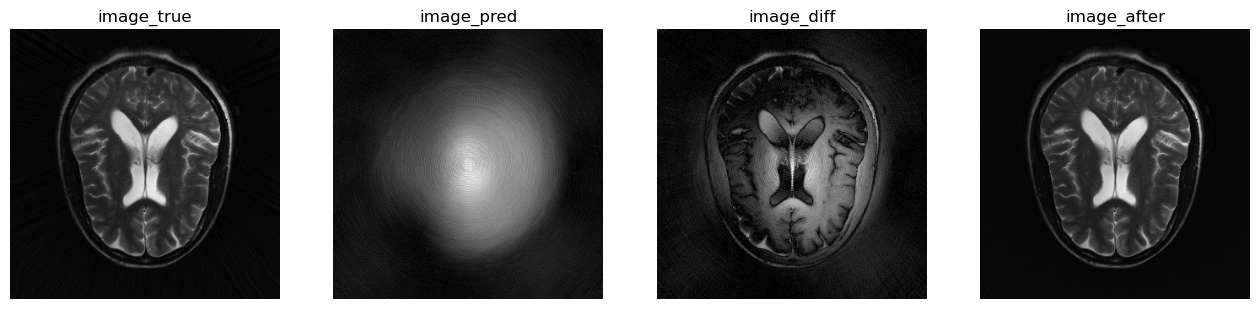

ssim: 0.7164350748062134
batch: 1, loss: 0.41822540760040283


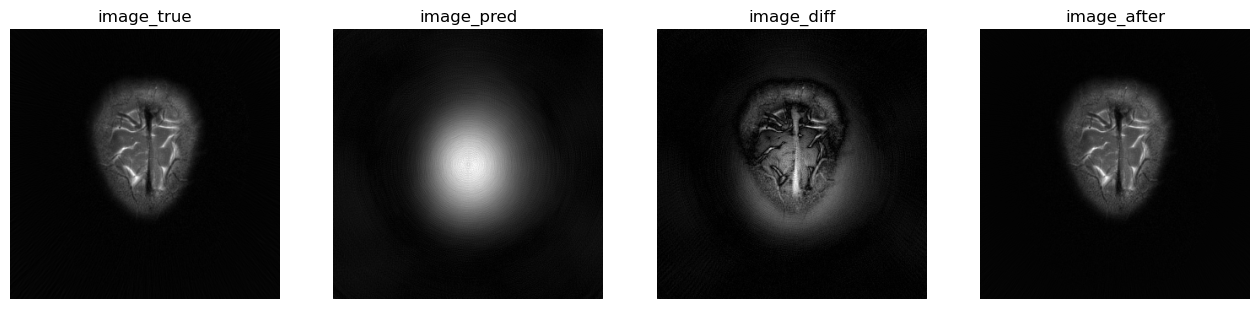

ssim: 0.7641671895980835
batch: 2, loss: 0.6016416549682617


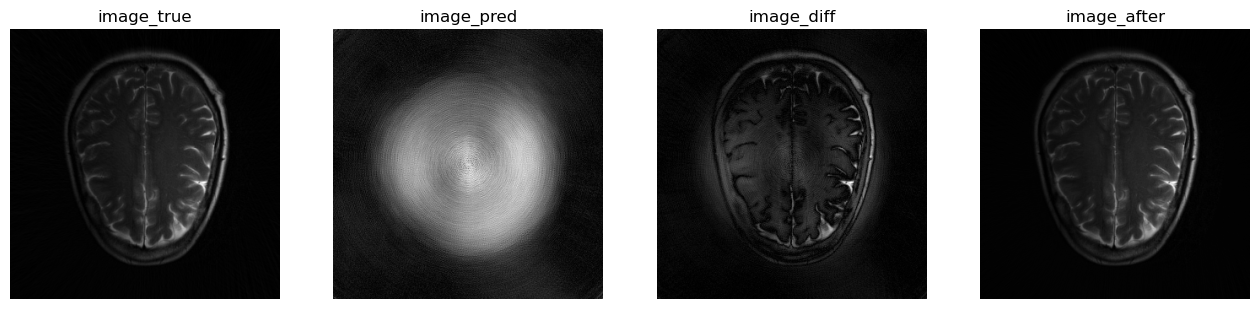

ssim: 0.6807835102081299
batch: 3, loss: 0.7648208737373352


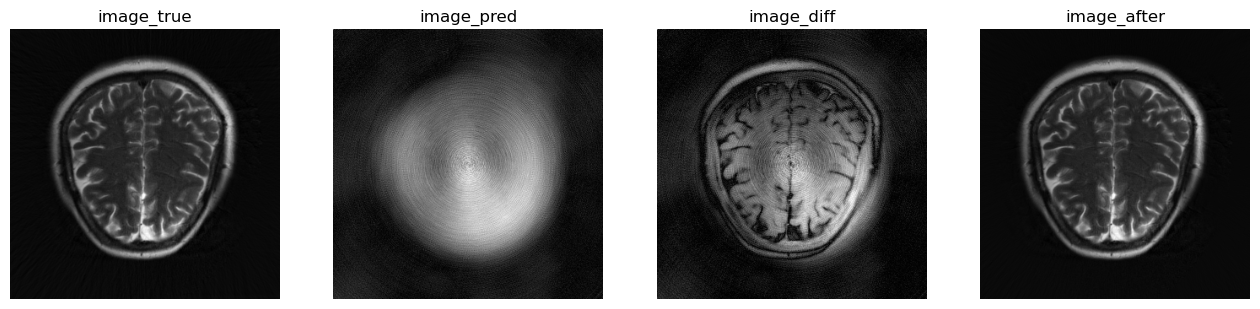

ssim: 0.6456208229064941
batch: 4, loss: 0.7491644024848938


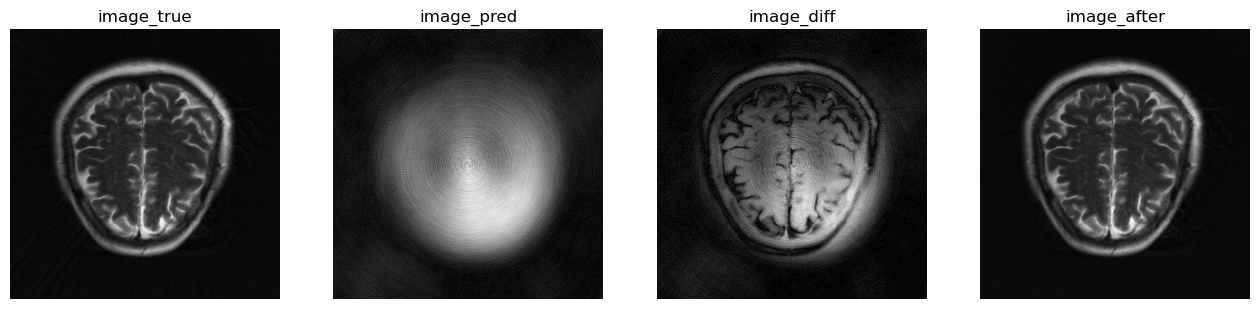

ssim: 0.6592203974723816
batch: 5, loss: 0.6556779146194458


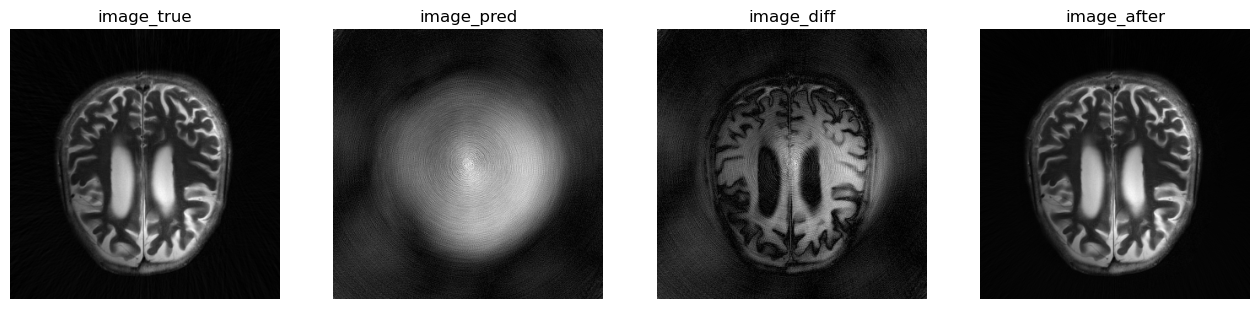

ssim: 0.6063097715377808
batch: 6, loss: 0.6797042489051819


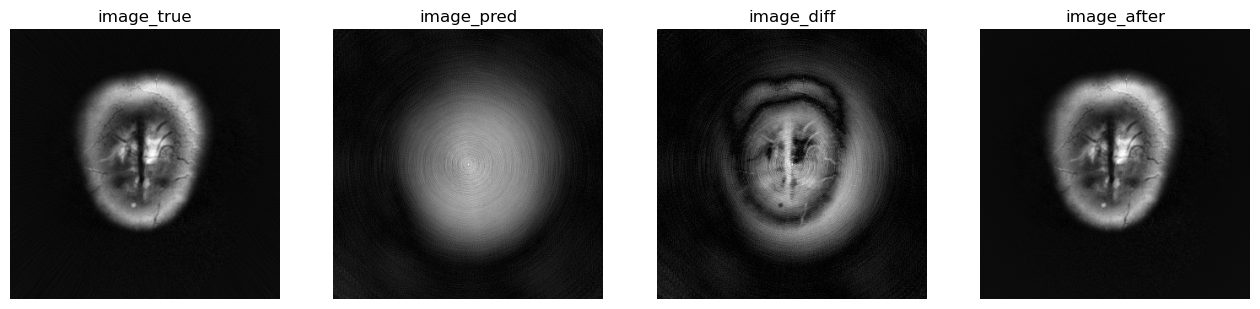

ssim: 0.6315540075302124


In [10]:
from email.mime import image
import torch
from torch.utils.data import DataLoader


def loss_func(pred, target):
    pred = mean_std_norm_complex(pred)
    target = mean_std_norm_complex(target)
    pred = myf.complex_to_real(pred)
    target = myf.complex_to_real(target)
    return F.mse_loss(pred, target)

model = MAE_Kradial(mask_ratio=0.75,
                    pts_readout=640,
                    in_channels=16,
                    out_channels=16,
                    d_model_encoder=1024,
                    d_model_decoder=512,
).to('cuda')

model.load_state_dict(torch.load("/home/liyy/data1/moco/exp/maekradialstep12024-11-02-19-36-56/model_290.pth"))


testloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

model.eval()

# dataenhance = Dataenhance(Motion(device = torch.device('cuda')))

def mean_std_norm_complex(data: torch.Tensor) -> torch.Tensor:
    real = data.real
    imag = data.imag
    real = (real - real.mean()) / real.std()
    imag = (imag - imag.mean()) / imag.std()
    return real + 1j * imag


def mean_std_norm_real(data: torch.Tensor) -> torch.Tensor:
    return (data - data.mean()) / data.std()


# ssim
from skimage.metrics import structural_similarity as ssim

with torch.no_grad():
    for i, data in enumerate(testloader):
        model.eval()
        with torch.no_grad():
            kspace_after = data['kspace_after'].to('cuda')
            image_after = model.inufft(kspace_after[0], data['pos_seq_after'].to('cuda')[0])
            image_pred, score, image_true = predict(model, data)

        loss = loss_func(image_pred, image_true)
        print(f"batch: {i}, loss: {loss.item ()}")

        image_true = myf.complex_to_real(image_true)
        image_pred = myf.complex_to_real(image_pred)

        image_true = mean_std_norm_real(image_true)
        image_pred = mean_std_norm_real(image_pred)

        # print(image_true.shape, image_pred.shape)

        ssim_score = ssim(image_true[0].cpu().numpy(), image_pred[0].cpu().numpy(), channel_axis=0, data_range=(image_true.max() - image_true.min()).cpu().numpy())

        image_true_show = myf.real_to_complex(image_true).cpu().abs()
        image_after_show = mean_std_norm_complex(image_after).cpu().abs()
        image_pred_show = myf.real_to_complex(image_pred).cpu().abs()

        image_diff_show = (image_true_show - image_pred_show).abs()

        from matplotlib import pyplot as plt

        plt.figure(figsize=(16, 4))
        plt.subplot(141)
        plt.imshow(image_true_show[0,0], cmap='gray')
        plt.title('image_true')
        plt.axis('off')
        plt.subplot(142)
        plt.imshow(image_pred_show[0,0], cmap='gray')
        plt.title('image_pred')
        plt.axis('off')
        plt.subplot(143)
        plt.imshow(image_diff_show[0,0], cmap='gray')
        plt.title('image_diff')
        plt.axis('off')
        plt.subplot(144)
        plt.imshow(image_after_show[0,0], cmap='gray')
        plt.title('image_after')
        plt.axis('off')
        
        plt.show()

        print(f"ssim: {ssim_score}")

        

        if i > 5:
            break